# Compare RAPIDS Decomposition Algorithms
Heavily influenced by https://umap-learn.readthedocs.io/en/latest/auto_examples/plot_algorithm_comparison.html#sphx-glr-auto-examples-plot-algorithm-comparison-py

## Notebook Credits
**Authorship**<br />
Original Author: Taurean Dyer  
Last Edit: Taurean Dyer, 9/25/2019<br />

**Test System Specs**<br />
Test System Hardware: GV100<br />
Test System Software: Ubuntu 18.04<br />
RAPIDS Version: 0.10.0a - Docker Install<br />
Driver: 410.79<br />
CUDA: 10.0<br />


**Known Working Systems**<br />
RAPIDS Versions: 0.4, 0.5, 0.5.1, 0.6, 0.6.1, 0.7, 0.8, 0.9, 0.10

## Intro
This notebook runs 3 of each of our decomposion methods (TSVD, PCA, and UMAP) through each of their respective algorithms or solvers.  This notebook should, and will, be updated as more methods or algorithms/solvers are added to cuML

## Neccessary pip installs
We need seaborn and matplotlib to do the visualization at the end

In [21]:
!pip install seaborn
!pip install matplotlib

## Import Libraries

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import dask_cudf
import cudf
import cuml
import pandas as pd
from sklearn import datasets, decomposition, manifold, preprocessing
from colorsys import hsv_to_rgb
import warnings
warnings.filterwarnings('ignore') ## Hides a known deprecation warning in UMAP that wll be fixed in 0.10.  You can comment it out if you really want to see it.

## Prepare and size your data

Things to note about the datasets:

- Blobs: A set of five gaussian blobs in 10 dimensional space. This should be a prototypical example of something that should clearly separate even in a reduced dimension space.
- Iris: a classic small dataset with one distinct class and two classes that are not clearly separated.
- Digits: handwritten digits – ideally different digit classes should form distinct groups. Due to the nature of handwriting digits may have several forms (crossed or uncrossed sevens, capped or straight line oes, etc.)
- Wine: wine characteristics ideally used for a toy regression. Ultimately the data is essentially one dimensional in nature.
- Swiss Roll: data is essentially a rectangle, but has been “rolled up” like a swiss roll in three dimensional space. Ideally a dimension reduction technique should be able to “unroll” it. The data has been coloured according to one dimension of the rectangle, so should form a rectangle of smooth color variation.
- Sphere: the two dimensional surface of a three dimensional sphere. This cannot be represented accurately in two dimensions without tearing. The sphere has been coloured with hue around the equator and black to white from the south to north pole.

In [23]:
## Just for kicks, we 10xed the samples compared to the original source code.  Cause we can.  
sns.set(context="paper", style="white")

blobs, blob_labels = datasets.make_blobs(
    n_samples=5000, n_features=10, centers=5, random_state=42
)
iris = datasets.load_iris()
digits = datasets.load_digits(n_class=10)
wine = datasets.load_wine()
swissroll, swissroll_labels = datasets.make_swiss_roll(
    n_samples=10000, noise=0.1, random_state=42
)
sphere = np.random.normal(size=(600, 3))
sphere = preprocessing.normalize(sphere)
sphere_hsv = np.array(
    [
        (
            (np.arctan2(c[1], c[0]) + np.pi) / (2 * np.pi),
            np.abs(c[2]),
            min((c[2] + 1.1), 1.0),
        )
        for c in sphere
    ]
)
sphere_colors = np.array([hsv_to_rgb(*c) for c in sphere_hsv])

## Call your algorithms and define your iterations

In [24]:
## Change your parameters so that you can see how it affects your results
nc = 2
rs = 42
nn = 30

## Iterate through our decomposition algorithms TSVD, h, and UMAP
reducers = [
    (cuml.TruncatedSVD(n_components=nc,algorithm='full', random_state=rs)),
    (cuml.TruncatedSVD(n_components=nc,algorithm='jacobi', random_state=rs)),
    (cuml.PCA(n_components=nc,svd_solver='full',whiten=False, random_state=rs)),
    (cuml.PCA(n_components=nc,svd_solver='jacobi',whiten=False, random_state=rs)),
    (cuml.UMAP(n_neighbors=nn, init="spectral"))
]

##  Iterate through your datasets
test_data = [
    (blobs, blob_labels),
    (iris.data, iris.target),
    (digits.data, digits.target),
    (wine.data, wine.target),
    (swissroll, swissroll_labels),
    (sphere, sphere_colors),
]

## Name your data
dataset_names = ["Blobs", "Iris", "Digits", "Wine", "Swiss Roll", "Sphere"]

## Helper variables
n_rows = len(test_data)
n_cols = len(reducers)
ax_index = 1
ax_list = []

## Size your plots
plt.rcParams["figure.figsize"] = [20,20]
plt.subplots_adjust(
    left=.2, right=10, bottom=.001, top=.96, wspace=.05, hspace=.1
)

<Figure size 1440x1440 with 0 Axes>

## Run your tests

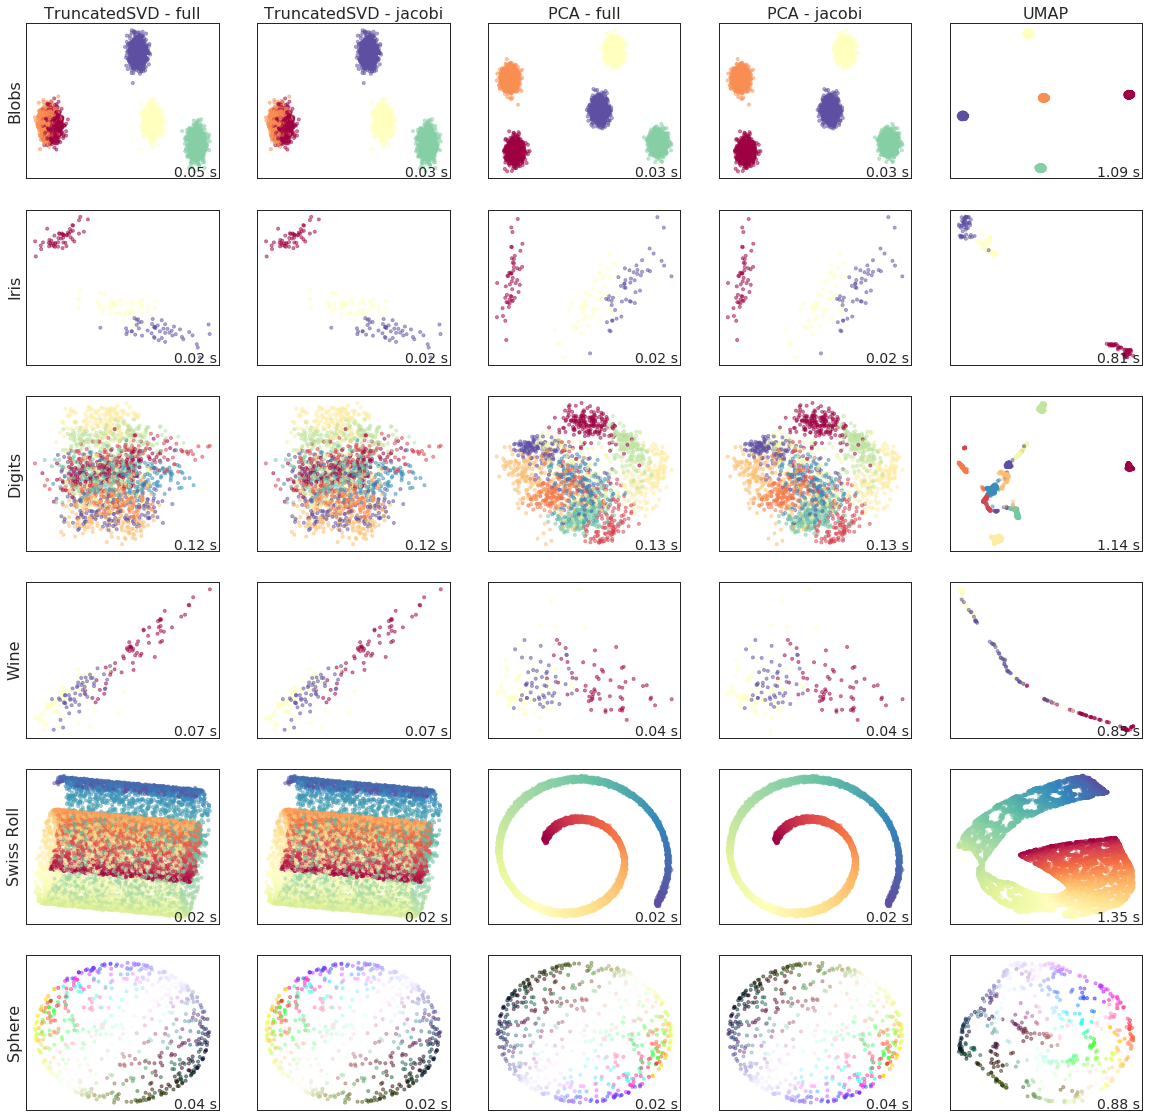

In [25]:
for data, labels in test_data:
    gdf=cudf.DataFrame.from_records(data) # skLearn data is a numpy ndarray, so we can just use "from_records" to put it into a cudf dataframe"
    for reducer in reducers:
        start_time = time.time()
        embedding = reducer.fit_transform(gdf)
        elapsed_time = time.time() - start_time
        ax = plt.subplot(n_rows, n_cols, ax_index)
        #print(embedding.T)
        embedding_numpy = embedding.to_pandas().values
        #pdb.set_trace()
        if isinstance(labels[0], tuple):
            ax.scatter(*embedding_numpy.T, s=10, c=labels, alpha=0.5)
        else:
            ax.scatter(
                *embedding_numpy.T, s=10, c=labels, cmap="Spectral", alpha=0.5
            )
        ax.text(
            0.99,
            0.01,
            "{:.2f} s".format(elapsed_time),
            transform=ax.transAxes,
            size=14,
            horizontalalignment="right",
        )
        ax_list.append(ax)
        ax_index += 1
plt.setp(ax_list, xticks=[], yticks=[])
for i in np.arange(n_rows) * n_cols:
    ax_list[i].set_ylabel(dataset_names[i // n_cols], size=16)
for i in range(n_cols):
    # automatically forming the column title from reducer representations
    title = repr(reducers[i])
    title = title.split("(")
    # Some reducers don't have an 'algorithm' or 'svd_solver' key
    try:
        title =  title[0] + " - "+ title[1].split("'")[1]
    except:
        title = title[0] 
    ax_list[i].set_xlabel(title , size=16)
    ax_list[i].xaxis.set_label_position("top")

#plt.tight_layout()
plt.show()

Checking out the images, you can see how different decomposition methods will cluster and represent your data.  This enables you to pick the best one for your uses.  You can change `rs`, `nc`, `nn` to see how the decomposition changes using the visualizations.  [You can compare these results to the CPU version here](https://umap-learn.readthedocs.io/en/latest/auto_examples/plot_algorithm_comparison.html#sphx-glr-auto-examples-plot-algorithm-comparison-py).  When comparing the timings, recall that we're working on a dataset 10x as big as the CPU version.